## Characteristic Reconstruction with $\tau \equiv \rho^{-1}$

In [1]:
from sympy import *
init_printing(use_unicode=True)

### Conserved variables
We start with the Euler equations in conservation-law form, with the vector of conserved variables $U$ and primitive variables $q$. Then we compute the $P$ matrix ($P_{ij} = \partial U_i / \partial q_j$) and the $Q_x$ matrix ($Q_{k,ij} = \partial F_{k,i} / \partial q_j$, where $F_k$ is the flux vector in the $k$ direction) (Sutherland and Kennedy, 2002). ($F$ denotes the fluxes of the conserved variables.)

*See also:* Zingale and Katz (2015).

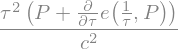

In [2]:
# define symbols
tau = Symbol('tau', positive=True) # specific volume (== 1/rho)
p = Symbol('P', positive=True) # pressure
u = Symbol('u') # normal velocity
v = Symbol('v') # transverse velocity
w = Symbol('w') # transverse velocity
s = Symbol('s') # passive scalar
c = Symbol('c') # sound speed
e_aux = Symbol('e_{aux}')

rho = 1/tau
e = Function('e')(rho, p) # specific internal energy
E = rho*e + rho*(u**2 + v**2 + w**2)/2 # total energy density

# compute de/drho
# (this is needed to rewrite the thermodynamic derivatives in terms of the sound speed)
dtau_drho = -rho**(-2)
p = Symbol('P', positive=True) # pressure
c = Symbol('c') # sound speed
e = Function('e')(rho, p) # specific internal energy
de_dp = solveset(Eq(c**2, (p - rho**2 * dtau_drho * Derivative(e, tau)) / (rho**2 * Derivative(e,p))), Derivative(e, p)).args[0].args[0]
de_dp

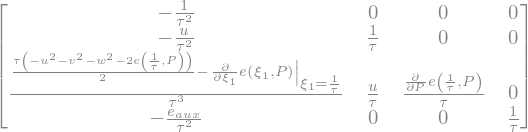

In [3]:
# compute the P matrix from Sutherland and Kennedy (2003)
U = Matrix([rho, rho*u, E, rho*e_aux])
q = Matrix([tau, u, p, e_aux])
P = simplify(Matrix(BlockMatrix(Derivative(U, q, evaluate=True).T)).T)
P

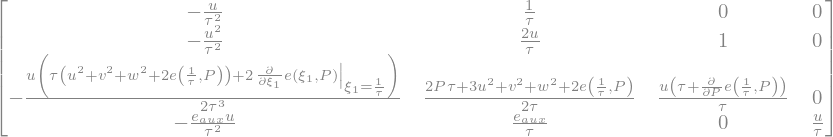

In [4]:
# compute the Q_n matrix
F_n = Matrix([rho*u,  # flux vector in normal direction
            rho*u**2 + p,
            (E + p)*u,
            rho*e_aux*u])
Q_n = simplify(Matrix(BlockMatrix(Derivative(F_n, q, evaluate=True).T)).T)
Q_n

### Primitive variables
Now we compute the coefficient matrix $A_x$ for the primitive equations ($A = P^{-1} Q$):

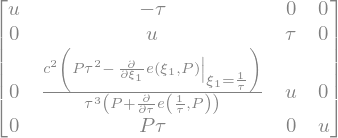

In [5]:
# compute the A_n matrix from Sutherland and Kennedy (2003)
# (this is the primitive variable flux matrix in the normal direction)
A_n = simplify(Inverse(P) * Q_n)
A_n = A_n.subs(Derivative(e,p), de_dp)

# add p dV term (cannot be written in conservation law form)
p_dV = Matrix([[0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, p*tau, 0, 0]])
A_n = A_n + p_dV
A_n

### Characteristic variables
We compute the eigenvalues $\lambda$ and eigenvectors $S$ of the $A_x$ matrix.

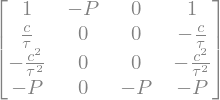

In [6]:
# compute the eigenvector matrix S
lambda_list = [eval for (eval, n, es) in A_n.eigenvects()]
R_list = [[ev for ev in es] for (v, n, es) in A_n.eigenvects()]
R = Matrix([[R_list[1][0].T],
               [R_list[0][0].T],
               [R_list[0][1].T],
               [R_list[2][0].T]]).T
R = simplify(R * (-p))
R = R.subs(e_aux + p/rho, Symbol('h'))
R

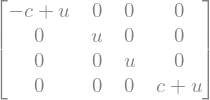

In [7]:
# compute eigenvalue matrix \lambda
Lambda = diag(lambda_list[1], lambda_list[0], lambda_list[0], lambda_list[2])
Lambda

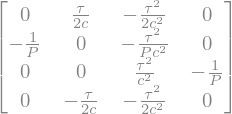

In [8]:
L = R.inv()
L

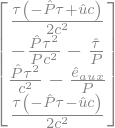

In [9]:
# compute L*q
q0 = Symbol(r'\hat \tau')
q1 = Symbol(r'\hat u')
q2 = Symbol(r'\hat P')
q3 = Symbol(r'\hat e_{aux}')
q = Matrix([q0, q1, q2, q3])
qp = simplify(L*q)
qp

In [10]:
q0 = Symbol(r'tau_hat')
q1 = Symbol(r'u_hat')
q2 = Symbol(r'P_hat')
q3 = Symbol(r'e_hat')
q = Matrix([q0, q1, q2, q3])
qp = simplify(L*q)

common_exprs_lower, final_expr_lower = cse(qp, list=False)
for var, val in common_exprs_lower:
    print(cxxcode(val, assign_to=var))
print(cxxcode(final_expr_lower, assign_to='charVars'))

x0 = P_hat*tau;
x1 = c*u_hat;
x2 = std::pow(c, -2);
x3 = (1.0/2.0)*tau*x2;
x4 = 1.0/P;
x5 = P_hat*std::pow(tau, 2)*x2;
charVars[0] = x3*(-x0 + x1);
charVars[1] = -tau_hat*x4 - x4*x5;
charVars[2] = -e_hat*x4 + x5;
charVars[3] = x3*(-x0 - x1);


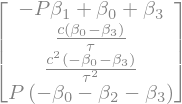

In [11]:
r0 = Symbol(r'\beta_0')
r1 = Symbol(r'\beta_1')
r2 = Symbol(r'\beta_2')
r3 = Symbol(r'\beta_3')
r = Matrix([r0, r1, r2, r3])
rp = simplify(R*r)
rp

In [12]:
r0 = Symbol(r'beta_0')
r1 = Symbol(r'beta_1')
r2 = Symbol(r'beta_2')
r3 = Symbol(r'beta_3')
r = Matrix([r0, r1, r2, r3])
rp = simplify(R*r)
common_exprs_lower, final_expr_lower = cse(rp, list=False)
for var, val in common_exprs_lower:
    print(cxxcode(val, assign_to=var))
print(cxxcode(final_expr_lower, assign_to='primVars'))

x0 = beta_0 + beta_3;
primVars[0] = -P*beta_1 + x0;
primVars[1] = c*(beta_0 - beta_3)/tau;
primVars[2] = -std::pow(c, 2)*x0/std::pow(tau, 2);
primVars[3] = P*(-beta_2 - x0);


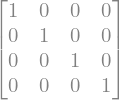

In [13]:
simplify(R*L)

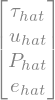

In [14]:
simplify(R*qp)